# **IMPORTS** 

In [18]:
# Imports here
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets,models,transforms,utils
import copy
import time
from collections import OrderedDict
from PIL import Image
from typing import Any
import math
import operator
import functools

# **CHECK ALLOCATED GPU** 

In [19]:
!nvidia-smi

Sun Jun 27 06:22:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **TORCH VERSION** 

In [20]:
torch.__version__

'1.9.0+cu102'

# **MOUNT DRIVE** 

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **MOVE TO DATA DIRECTORY** 

In [22]:
cd gdrive/MyDrive/SqueezeNet/dataset/

/content/gdrive/MyDrive/SqueezeNet/dataset


# **LOAD IMAGES & LABELS FROM .MAT FILE** 

In [23]:
import scipy.io
images = scipy.io.loadmat('dtd_white_indoor_6600artimg.mat')['allartimgs1']
labels = scipy.io.loadmat('dtd_white_indoor_6600corners.mat')['allcorners1']

# **DEFINING TRANSFORM FOR DATA PREPROCESSING** 

In [24]:
from torchvision import transforms
transform = transforms.Compose([
            #transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
transform(images[1]).size()

torch.Size([3, 384, 256])

In [26]:
transform(images[1])

tensor([[[0.4508, 0.4679, 0.4508,  ..., 0.6221, 0.6221, 0.6563],
         [0.4508, 0.4337, 0.4508,  ..., 0.6392, 0.6392, 0.6563],
         [0.4337, 0.4166, 0.4337,  ..., 0.6392, 0.6392, 0.6563],
         ...,
         [0.2453, 0.2453, 0.2111,  ..., 1.1015, 1.1529, 1.1187],
         [0.2453, 0.2282, 0.2111,  ..., 1.0673, 1.1187, 1.0502],
         [0.2453, 0.2111, 0.1939,  ..., 1.0673, 1.0844, 1.0159]],

        [[0.5553, 0.5553, 0.5378,  ..., 0.7304, 0.7304, 0.7654],
         [0.5378, 0.5378, 0.5378,  ..., 0.7479, 0.7479, 0.7654],
         [0.5378, 0.5203, 0.5378,  ..., 0.7479, 0.7479, 0.7654],
         ...,
         [0.3452, 0.3452, 0.3102,  ..., 1.2206, 1.2731, 1.2381],
         [0.3452, 0.3277, 0.3102,  ..., 1.1856, 1.2381, 1.1681],
         [0.3452, 0.3102, 0.3102,  ..., 1.2031, 1.2031, 1.1331]],

        [[0.7751, 0.7751, 0.7576,  ..., 0.9494, 0.9494, 0.9842],
         [0.7576, 0.7576, 0.7576,  ..., 0.9668, 0.9668, 0.9842],
         [0.7576, 0.7402, 0.7576,  ..., 0.9668, 0.9668, 0.

In [27]:
images_tensor = torch.empty(6615,3,384,256).cuda()
y = 0
for i in range(6615):
  y += 1
  images_tensor[i] = transform(images[i])
  if y % 500 == 0:
    print(y)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500


In [28]:
print(images_tensor.size())
labels = torch.from_numpy(labels)
print(labels.size())

torch.Size([6615, 3, 384, 256])
torch.Size([6615, 8])


In [29]:
labels[6000] 

tensor([ 92.3213, 132.3761, 148.7622, 124.1709, 169.7260, 334.2222,  81.8394,
        323.2821], dtype=torch.float64)

In [30]:
images_tensor[6000]

tensor([[[-0.5767, -0.5082, -0.3883,  ..., -0.7137, -0.7650, -0.7650],
         [-0.5767, -0.4911, -0.3883,  ..., -0.7308, -0.7822, -0.7993],
         [-0.5596, -0.4911, -0.3883,  ..., -0.7479, -0.7993, -0.8335],
         ...,
         [ 0.0398,  0.0569,  0.0741,  ...,  0.6734,  0.6392,  0.6392],
         [ 0.0398,  0.0569,  0.0741,  ...,  0.6563,  0.6221,  0.6221],
         [ 0.0398,  0.0569,  0.0741,  ...,  0.6392,  0.6049,  0.6049]],

        [[-0.7752, -0.7052, -0.5476,  ..., -0.9153, -0.9503, -0.9503],
         [-0.7752, -0.6877, -0.5476,  ..., -0.9328, -0.9678, -0.9853],
         [-0.7752, -0.6702, -0.5476,  ..., -0.9503, -0.9853, -1.0203],
         ...,
         [ 0.0651,  0.0826,  0.1001,  ...,  0.7129,  0.6779,  0.6779],
         [ 0.0651,  0.0651,  0.1001,  ...,  0.6954,  0.6604,  0.6604],
         [ 0.0651,  0.0651,  0.1001,  ...,  0.6779,  0.6429,  0.6429]],

        [[-0.8458, -0.7587, -0.6367,  ..., -1.0898, -1.1247, -1.1596],
         [-0.8458, -0.7587, -0.6367,  ..., -1

# **LOADING DATA IN BATCHES** 

In [31]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(images_tensor, labels)
train_dataloader = DataLoader(train_dataset, batch_size=64)

In [32]:
batch = next(iter(train_dataloader))
print(batch[0].shape)
print(batch[1].shape)

torch.Size([64, 3, 384, 256])
torch.Size([64, 8])


# **DOWNLOADING THE MODEL** 

In [33]:
model = models.squeezenet1_1(pretrained=True)
#model.eval()

# **REFINING THE MODEL AND CHECKING PARAMETERS** 

In [34]:
for param in model.parameters():
    param.requires_grad=False

model.classifier._modules['4'] = nn.Flatten()
model.classifier._modules['5'] = nn.Linear(1000, 8)

# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

1,243,504 total parameters.
8,008 trainable parameters.


# **MODEL ARCHITECTURE** 

In [35]:
model.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [36]:
print(model.forward(torch.rand(16,3,384,256)).size())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([16, 8])


# **CHECK DEVICE** 

In [37]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if(device.type=="cuda"):
  print("Running on CUDA")

Running on CUDA


In [38]:
model = model.cuda()

In [39]:
model.classifier[5]

Linear(in_features=1000, out_features=8, bias=True)

In [40]:
print([i for i in model.classifier[5].parameters()][0].shape)
print([i for i in model.classifier[5].parameters()][1].shape)

torch.Size([8, 1000])
torch.Size([8])


In [41]:
[i for i in model.classifier[5].parameters()][0]

Parameter containing:
tensor([[-0.0132,  0.0253, -0.0254,  ...,  0.0089, -0.0245,  0.0253],
        [ 0.0224,  0.0121, -0.0167,  ...,  0.0212, -0.0105,  0.0142],
        [-0.0203,  0.0315,  0.0073,  ..., -0.0198, -0.0082,  0.0188],
        ...,
        [-0.0175,  0.0205,  0.0124,  ...,  0.0101,  0.0211, -0.0101],
        [-0.0195,  0.0057, -0.0094,  ..., -0.0261,  0.0245,  0.0013],
        [ 0.0039, -0.0266,  0.0228,  ..., -0.0207, -0.0240, -0.0202]],
       device='cuda:0', requires_grad=True)

# **TRAINING THE MODEL** 

In [79]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20,device='cuda'):
      
      since = time.time()
      train_loss = []
      model = model.double()
      

      for epoch in range(num_epochs):  # loop over the dataset multiple times
            
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('lr: {}'.format(optimizer.param_groups[0]['lr']))
            print('-' * 10)
            i = 0
            running_loss = 0.0
            model = model.train()

            for inputs,labels in train_dataloader:
                i += 1
                # get the inputs; data is a list of [inputs, labels] 
                
                #print(inputs.shape)
                #print(labels.shape)
                
                inputs = inputs.cuda()
                labels = labels.cuda()
      
                inputs = inputs.double()
                
                with torch.set_grad_enabled(True):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimizer + scheduler
                    
                    outputs = model.forward(inputs)
                    #print(outputs.shape)

                    loss = criterion(outputs.flatten(), labels.flatten())
                    #print('Loss in iteration: ',i,'is equal to ',loss)
            
                    #loss.requires_grad = True
                    loss.backward()
                    optimizer.step()
                    

                # print statistics
                running_loss += loss.item() * inputs.size()[0]
                 
                if i % 100 == 0:
                  print('Iteration: ',i)
                  print('Running Loss: ',running_loss)
                  print([i for i in model.classifier[1].parameters()][0][0:2])
            
            scheduler.step()

            train_loss.append(running_loss/6615)
            print('----------')
            print('Train Loss: ',train_loss[-1])
            running_loss = 0.0
      
      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
      return model, train_loss

# **LOSS FUNCTION, OPTIMIZER, SCHEDULER** 

In [43]:
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.classifier[5].parameters(), lr=0.1) 
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)

# **RUN TRAIN MODEL** 

In [44]:
#model, train_loss = train_model(model, loss_fn, optimizer, scheduler, num_epochs = 5)

# **SAVE AND LOAD MODEL STATE DICT** 

In [45]:
checkpoint = 'checkpoint_squeezenet_11.pth'
path = '/content/gdrive/MyDrive/SqueezeNet/model_state_dict/' + checkpoint
#Saving the model state dict
#torch.save(model.state_dict(), path)

# Loading the model state dict
model.load_state_dict(torch.load(path))
model.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [46]:
[i for i in model.classifier[5].parameters()][0]

Parameter containing:
tensor([[-0.0659,  0.7990,  0.2862,  ..., -0.2987,  0.4054,  0.3052],
        [-0.7859,  0.5596, -0.9644,  ...,  0.4771, -0.0659,  0.9440],
        [ 0.0608,  1.6347, -0.6275,  ...,  0.0630,  0.9143,  0.2853],
        ...,
        [ 0.1472,  0.3086, -1.4875,  ..., -0.9243,  0.9746,  1.1711],
        [-0.4517,  0.9764,  0.2157,  ..., -0.4598,  0.1572,  0.3181],
        [ 0.2072,  0.4757, -0.7013,  ..., -0.5231,  0.7548,  1.2804]],
       device='cuda:0', requires_grad=True)

# **TESTING THE MODEL** 

In [47]:
preds = model.forward(images_tensor[2000].unsqueeze(0).cuda())

In [48]:
preds

tensor([[ 75.1261,  62.0676, 147.5761,  59.9913, 156.9502, 243.7934,  75.6753,
         249.3670]], device='cuda:0', grad_fn=<AddmmBackward>)

In [49]:
labels[2000]

tensor([ 79.0438,  89.6000, 158.0876,  76.2182, 168.2869, 299.6364,  83.1235,
        260.0727], dtype=torch.float64)

In [50]:
loss_fn(preds.flatten().cuda(),labels[2000].cuda())

tensor(570.5285, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward>)

In [51]:
img = images_tensor[2000].detach().to('cpu').numpy()
img = np.transpose(img, (1, 2, 0))
img.shape

(384, 256, 3)

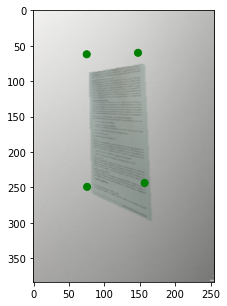

In [53]:
fig,ax = plt.subplots(figsize=(5,5))
imshow(images_tensor[2000],list(preds.detach().to('cpu').numpy().flatten()))

# **CORNER PATCH CROP**

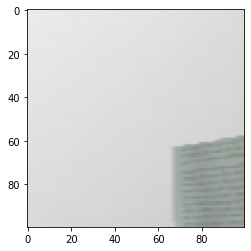

In [54]:
im1 = img[75-50:75+50,62-50:62+50]
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
im1 = std * im1 + mean
im1 = np.clip(im1, 0, 1)
plt.imshow(im1)
#plt.savefig('CornerImg.png')

# **CORNER DETECTOR REFINER**

In [55]:
rgb_weights = [0.2989, 0.5870, 0.1140]
grayscale_image = np.dot(im1[...,:3], rgb_weights)
#grayscale_image.shape
threshold = 0.8
binarized = 1.0 * (grayscale_image > threshold)

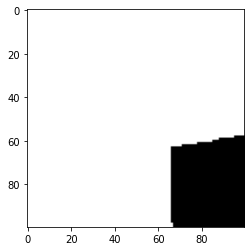

In [56]:
plt.imshow(binarized,'gray')
plt.show()

In [57]:
xy = [1000,1000]
for i in range(im1.shape[0]):
  for j in range(im1.shape[1]):
    if binarized[i,j] == 0:
      try:
        if binarized[i-1,j-1] == 1 and binarized[i-1,j] == 1 and binarized[i,j-1] == 1:
          if i+j < sum(xy):
            xy = [i,j]
      except:
        pass
xy

[63, 66]

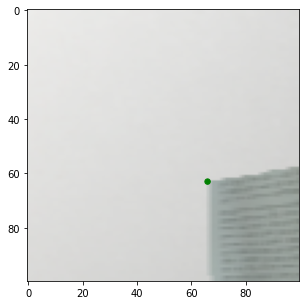

In [58]:
xx, yy = xy
fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(im1)
circ = Circle((yy,xx),1,color='g')
ax.add_patch(circ)
plt.show()

# **SQUEEZE-NET VARIANT 2**

In [12]:
sqnet = models.squeezenet1_1(pretrained=True)

In [16]:
sqnet.classifier[1] = nn.Conv2d(512, 8, kernel_size=(1,1), stride=1)

for param in sqnet.parameters():
    param.requires_grad=False

for param in sqnet.classifier.parameters():
    param.requires_grad=True

# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in sqnet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in sqnet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

726,600 total parameters.
4,104 trainable parameters.


In [66]:
sqnet.cuda()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [91]:
lossA = torch.nn.MSELoss(reduction='mean')
optimizerA = optim.Adam(sqnet.classifier[1].parameters(), lr=0.000001) 
schedulerA = optim.lr_scheduler.StepLR(optimizerA,step_size=10,gamma=0.1)

In [92]:
sqnet, train_loss = train_model(sqnet, lossA, optimizerA, schedulerA, num_epochs = 5)

Epoch 0/4
lr: 1e-06
----------
Iteration:  100
Running Loss:  8301058.691881334
tensor([[[[ -0.7345]],

         [[ -2.4482]],

         [[  0.5718]],

         ...,

         [[-16.3303]],

         [[ -4.7146]],

         [[ -9.0781]]],


        [[[ -3.1084]],

         [[  1.2767]],

         [[ -0.4630]],

         ...,

         [[ -1.0880]],

         [[  4.6825]],

         [[  6.9150]]]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SliceBackward>)
----------
Train Loss:  1296.9317553265219
Epoch 1/4
lr: 1e-06
----------
Iteration:  100
Running Loss:  8261449.134487055
tensor([[[[ -0.7346]],

         [[ -2.4482]],

         [[  0.5718]],

         ...,

         [[-16.3303]],

         [[ -4.7146]],

         [[ -9.0781]]],


        [[[ -3.1084]],

         [[  1.2767]],

         [[ -0.4630]],

         ...,

         [[ -1.0879]],

         [[  4.6825]],

         [[  6.9150]]]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SliceBackward>)
----------
Trai

In [93]:
checkpoint = 'checkpoint_squeezenet_variant2.pth'
path = '/content/gdrive/MyDrive/SqueezeNet/model_state_dict/' + checkpoint
#Saving the model state dict
torch.save(sqnet.state_dict(), path)

# Loading the model state dict
#sqnet.load_state_dict(torch.load(path))
#sqnet.eval()

# **TESTING SQUEEZE-NET VARIANT 2**

In [95]:
preds = sqnet.forward(images_tensor[2000].double().unsqueeze(0).cuda())

In [96]:
preds

tensor([[ 77.2952,  77.1264, 160.1817,  78.8406, 171.3610, 275.4337,  73.8172,
         273.2438]], device='cuda:0', dtype=torch.float64,
       grad_fn=<ViewBackward>)

In [97]:
labels[2000]

tensor([ 79.0438,  89.6000, 158.0876,  76.2182, 168.2869, 299.6364,  83.1235,
        260.0727], dtype=torch.float64)

In [98]:
loss_fn(preds.flatten().cuda(),labels[2000].cuda())

tensor(128.1517, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward>)

In [99]:
img = images_tensor[2000].detach().to('cpu').numpy()
img = np.transpose(img, (1, 2, 0))
img.shape

(384, 256, 3)

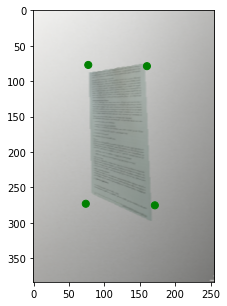

In [100]:
fig,ax = plt.subplots(figsize=(5,5))
imshow(images_tensor[2000],list(preds.detach().to('cpu').numpy().flatten()))

# **-----UTILS-----**

# **DISPLAYING RESULTS**

In [ ]:
from matplotlib.patches import Circle

def imshow(inp, preds):
    inp = inp.detach().to('cpu').numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)

    for i in range(0,len(preds),2):
      xx,yy = (preds[i],preds[i+1])
      circ = Circle((xx,yy),5,color='g')
      ax.add_patch(circ)

    plt.show()

# **PRINTING CURRENTLY ALIVE TENSORS AND VARIABLES** 

In [ ]:
# prints currently alive Tensors and Variables
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

# **TRAIN-VALID SPLIT** 

In [ ]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [5600, 1015])
print('Training set size:',len(train_set))
print('Validation set size:',len(val_set))

Training set size: 5600
Validation set size: 1015
